In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [7]:
Base = automap_base()

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns_m = inspector.get_columns('measurement')
columns_s = inspector.get_columns('station')
for column in columns_m:
    print(column["name"], column["type"])

print(f'-----------')
for column in columns_s:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)


In [12]:
# reflect the tables
#do I have to do this with a declarative base, when automap base as been defined above already?

In [13]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
year_ago = recent_date - dt.timedelta(days=365)
print(year_ago)


2016-08-23


In [36]:
# Perform a query to retrieve the date and precipitation scores
session.query(Measurement) \
    .with_entities(
        Measurement.date, 
        sqlalchemy.func.sum(Measurement.prcp)
).group_by(
        Measurement.date
).count()


2792

In [86]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(session.query(Measurement) \
    .with_entities(
        Measurement.date, 
        sqlalchemy.func.sum(Measurement.prcp)
).group_by(
        Measurement.date
).all(), columns = ('date', 'precipitation'))

precip_year_df = precip_df[precip_df['date'] >= '2016-08-23']

precip_year_df=precip_year_df.set_index('date', drop=True)


# Sort the dataframe by date
precip_year_df=precip_year_df.sort_values(by='date')

precip_year_df

,precipitation
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


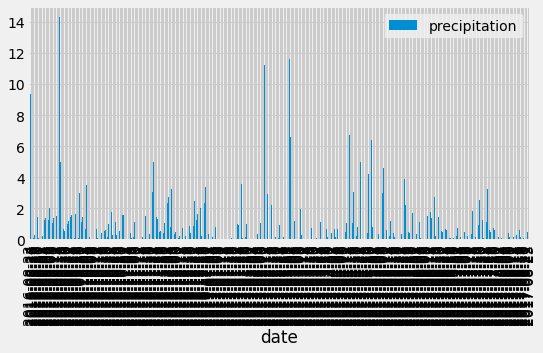

In [88]:
# Use Pandas Plotting with Matplotlib to plot the data
bar1 = precip_year_df.plot(kind='bar', figsize=(8,4), rot=90)

xticklabes = ['2016-08-23']
#bar1.set_xticklabels(xticklabels, rotation=90, rotation_mode='anchor', ha='right', wrap=True)

plt.show()

In [92]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_table = precip_year_df.agg({"precipitation":["mean", "median", "var", "std", "sem"]})
summary_table

,precipitation
mean,0.978907
median,0.405000
var,3.155417
std,1.776349
sem,0.092851


# Exploratory Station Analysis

In [96]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement).group_by(Measurement.station).count()

9

In [101]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement) \
    .with_entities(
        Measurement.station, 
        func.count(Measurement.station)
).group_by(
        Measurement.station
).order_by(
        func.count(Measurement.station).desc()
).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [102]:
# Close Session
session.close()